#The Fluties - 2020
Here is a statiscial analysis of the 2020 regular season.

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy
from scipy import stats
import statsmodels.api as sm
from sklearn import linear_model

full_teams = pd.read_csv("teams.csv")
teams = full_teams.loc[full_teams["year"] == 2020]
reg_teams = teams


##Final Regular Season Standings
Here is the league ordered by Playoff seed. The order is determined first by division winners and then by record. This explains the 6-7 team that is the #4 seed. This is the core data that we will use to find the correlation between points for, points against, and wins.

The hypothesis is that the more points you score and the more active you are with your roster the more wins you will have. These are two of the main things that you actively and directly control.

In [2]:
teams[["abbrev", "location", "nickname", "record.overall.wins", "record.overall.losses", "playoffSeed", "record.overall.pointsFor", "record.overall.pointsAgainst", "transactionCounter.moveToActive"]].sort_values("playoffSeed").head(12)

,abbrev,location,nickname,record.overall.wins,record.overall.losses,playoffSeed,record.overall.pointsFor,record.overall.pointsAgainst,transactionCounter.moveToActive
0,#1,Lanford,Lions,11,2,1,1899.1,1624.8,74
8,faq,hot chubb,time machine,10,3,2,2064.4,1557.2,57
6,BBc,Chubby,Chaser,9,4,3,2006.9,1714.0,37
2,Seth,Lord,Of Glencoe,6,7,4,1552.3,1714.6,31
1,GUY,Flavortown,Fieris,8,5,5,1805.0,1757.0,30
10,No,Fear the,Ginjaninja,7,6,6,1797.7,1656.0,63
3,TMB,Will ❤ the,Demigorgon,7,6,7,1636.3,1562.1,34
7,#50%,Autodraft,Kids,7,6,8,1694.8,1740.9,47
9,JJJ,COVID,19,5,8,9,1614.0,1712.4,26
4,Mill,Circus Circus,ðª,4,9,10,1586.9,1720.2,48


##Statiscal Analysis of Points For and Against

A quick peek to understand the where all the teams fall in the context of the league.

Some quick observations:
- The variance of points against is a lot tighter than points for.
- The exception being MAGA which by far and away an outlier with 1912 points against.
- MAGA and TWS both are the two lowest scoring and highest points against teams. 

In [3]:
teams["record.overall.pointsFor"].describe()

count      12.000000
mean     1705.825000
std       214.864029
min      1371.700000
25%      1578.250000
50%      1665.550000
75%      1828.525000
max      2064.400000
Name: record.overall.pointsFor, dtype: float64

In [4]:
teams["record.overall.pointsAgainst"].describe()

count      12.000000
mean     1705.825000
std        98.736906
min      1557.200000
25%      1648.200000
50%      1714.300000
75%      1744.925000
max      1912.300000
Name: record.overall.pointsAgainst, dtype: float64

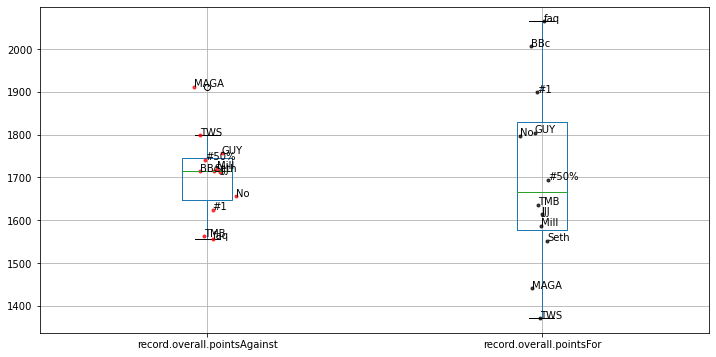

In [5]:
ax = teams.boxplot(column=["record.overall.pointsAgainst", "record.overall.pointsFor"], figsize=(12,6))
for index, t in teams.iterrows():
    y = t["record.overall.pointsFor"]
    x = np.random.normal(2, 0.04)
    ax.plot(x, y, 'k.', alpha=0.75)
    ax.text(x, y, t["abbrev"])
    y_for = t["record.overall.pointsAgainst"]
    x_for = np.random.normal(1, 0.04)
    ax.plot(x_for, y_for, 'r.', alpha=0.75)
    ax.text(x_for, y_for, t["abbrev"])

##Grouped by Division

This is the same data, but now grouped by each division.

The main thing I see here is that division 1 is far below the the other divisions. The highest scoring team would be third in every other division. Essentially it is the NFC East.

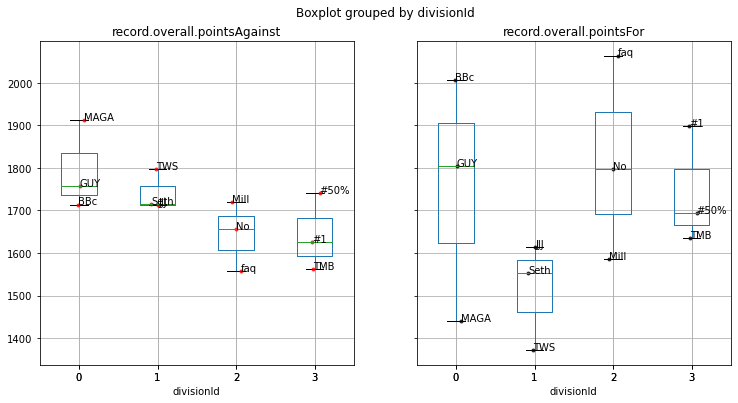

In [6]:
ax = teams.boxplot(column=["record.overall.pointsAgainst", "record.overall.pointsFor"], by="divisionId", figsize=(12,6))
for index, t in teams[["record.overall.pointsFor", "record.overall.pointsAgainst", "abbrev", "divisionId"]].iterrows():
    y = t["record.overall.pointsAgainst"]
    yfor = t["record.overall.pointsFor"]
    x = np.random.normal(t["divisionId"]+1, 0.05)
    ax[0].plot(x, y, 'r.', alpha=0.75)
    ax[0].text(x, y, t["abbrev"])
    ax[1].plot(x, yfor, 'k.', alpha=0.75)
    ax[1].text(x, yfor, t["abbrev"])

##Regression Analytics

The next step is to just do some linear regression on wins with the relationship to points for, points against, and move to active (activations in your roster).

The relationship of wins to points for is strong. This intuitively makes sense. The more points you score the more wins you should have. 

Points against is negatively correlated with wins. Which again makes sense, but it is much weaker. 

Move to action is a positive relationship and pretty weak. 

In [7]:
for_mod = sm.OLS(reg_teams['record.overall.wins'], sm.add_constant(reg_teams['record.overall.pointsFor']))
for_res = for_mod.fit()

against_mod = sm.OLS(reg_teams['record.overall.wins'], sm.add_constant(reg_teams['record.overall.pointsAgainst']))
against_res = against_mod.fit()

moves_mod = sm.OLS(reg_teams['record.overall.wins'], sm.add_constant(reg_teams['transactionCounter.moveToActive']))
moves_res = moves_mod.fit()

In [8]:
for_res.rsquared

0.8425327479286435

In [9]:
against_res.rsquared

0.5246625214619729

In [10]:
moves_res.rsquared

0.5227580644994096

##Plotted Charts

We can now visualize the correlation between each of points for, points against, and moves.

Notice how close all the points are to the fitted line for points for. The other two charts definitely show that they are correlated, but there is more variance.

The teams that are above the line have more wins than each model would predict. The perfect teams to look at are TMB, #50%, and No. All these teams have 7 wins, but vastly different points for, points against, and moves. 

This is also clear if you look vertically at 1600 points for. Scoring that many points will get you anywhere between 4-7 wins.

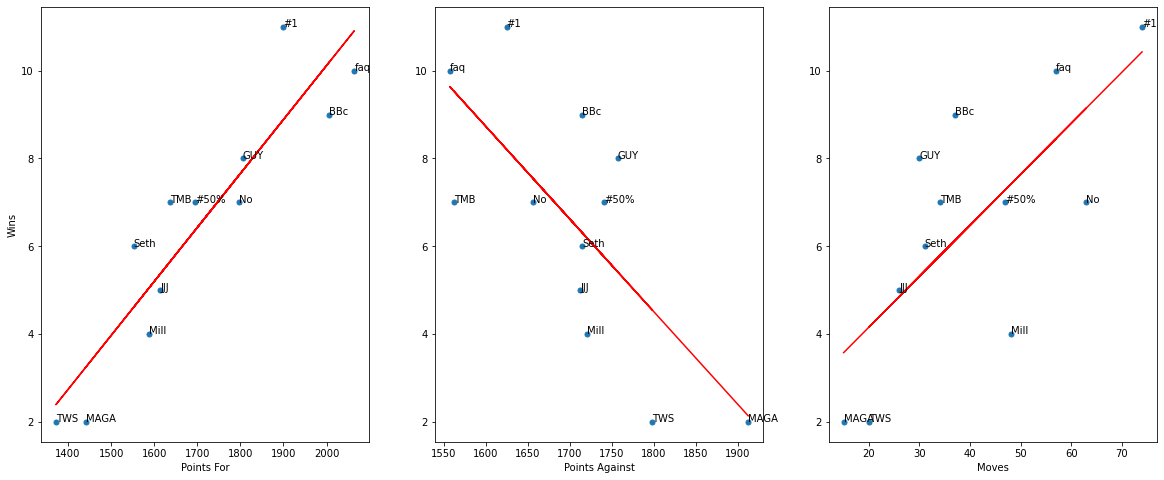

In [11]:
def regress_plot(slope, intercept, x, y, plt):
    plt.plot(x, y, 'o', markersize=5)

    plt.plot(x, slope*x + intercept, 'r')
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
regress_plot(for_res.params[1], for_res.params[0], teams['record.overall.pointsFor'], teams['record.overall.wins'], ax[0])
regress_plot(against_res.params[1], against_res.params[0], teams['record.overall.pointsAgainst'], teams['record.overall.wins'], ax[1])
regress_plot(moves_res.params[1], moves_res.params[0], teams['transactionCounter.moveToActive'], teams['record.overall.wins'], ax[2])
ax[0].set_xlabel('Points For')
ax[0].set_ylabel('Wins')
ax[1].set_xlabel('Points Against')
ax[2].set_xlabel('Moves')


for index, t in teams.iterrows():
    ax[0].text(t['record.overall.pointsFor'], t['record.overall.wins'], t['abbrev'])
    ax[1].text(t['record.overall.pointsAgainst'], t['record.overall.wins'], t['abbrev'])
    ax[2].text(t['transactionCounter.moveToActive'], t['record.overall.wins'], t['abbrev'])

##Multiple Variable Regression

I played around with various columns to find the best fitting results. I landed on points for and points against. This has yielded R-squared of 0.853. This is pretty high. 

I initially had Move to Active in the regression initially and it did increase R-squared, but it reduced the statistical significance. There is a correlation with it as a single variable, but my estimation is that that significance is more than made up in the points for variable.

In [12]:
mod = sm.OLS(reg_teams['record.overall.wins'], sm.add_constant(reg_teams[['record.overall.pointsFor','record.overall.pointsAgainst']]))
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
=============================================================================
Model:                 OLS                    Adj. R-squared:        0.853   
Dependent Variable:    record.overall.wins    AIC:                   38.9206 
Date:                  2020-12-09 15:59       BIC:                   40.3753 
No. Observations:      12                     Log-Likelihood:        -16.460 
Df Model:              2                      F-statistic:           33.01   
Df Residuals:          9                      Prob (F-statistic):    7.18e-05
R-squared:             0.880                  Scale:                 1.2131  
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
-----------------------------------------------------------------------------
const                         1.3909   9.8180  0.1417 0.8905 -20.8189 23.6008
record.overall.pointsFor      0.0102   0.0020  5.1630 0.0006   0.0057  0.0147
record.overall.pointsAgainst -0.0072   0.0043 -1.6770 0.1279  -0.0170  0.0025
-----------------------------------------------------------------------------
Omnibus:                  1.109            Durbin-Watson:               1.078
Prob(Omnibus):            0.574            Jarque-Bera (JB):            0.907
Skew:                     0.539            Prob(JB):                    0.635
Kurtosis:                 2.194            Condition No.:               74579
=============================================================================
* The condition number is large (7e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

##Correction to Wins

Now that we have a linear model, with a high correlation, that includes points for and points against. We can now make predictions based on how many points the team scored and how many points the opposing team scored. 

The next chart shows the correction. A negative value means that the team underperformed. The model predicts more wins because the amount of points scored suggests that. Or the opposing team scored less and would predict a win. 

The opposite is true as well. A postive number means that the team overperformed. The team may have scored fewer points, but was matched up against a team that scored even fewer. 

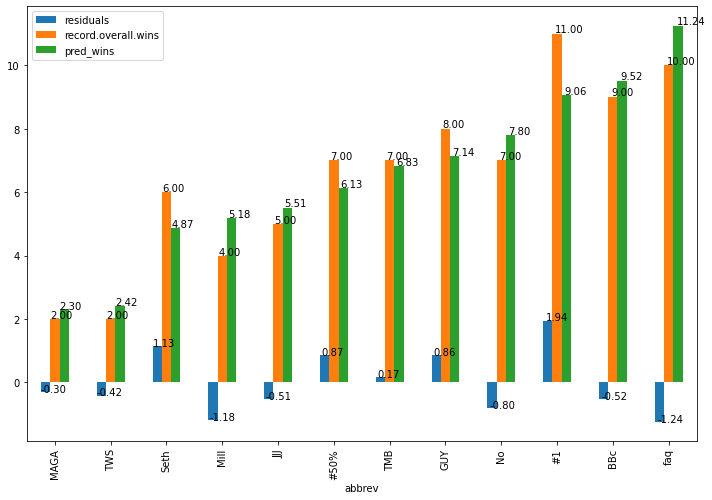

In [13]:
teams["residuals"] = res.resid
teams["pred_wins"] = res.fittedvalues

ax = teams[["residuals", "record.overall.wins", "pred_wins", "abbrev"]].set_index("abbrev").sort_values("pred_wins").plot(kind="bar", figsize=(12,8))
for p in ax.patches:
    ax.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##The Predicted Standings

Here we see the prediction of wins for each team based on how many points they scored and how many against. 

In [14]:
teams["pred_win%"] = teams["pred_wins"] / (teams["record.overall.wins"] + teams["record.overall.losses"])
output = teams[["abbrev", "record.overall.wins", "pred_wins", "pred_win%", "playoffSeed"]].sort_values("pred_win%", ascending=False).reset_index(drop=True)
output.index +=1
output.head(12)

,abbrev,record.overall.wins,pred_wins,pred_win%,playoffSeed
1,faq,10,11.236207,0.864324,2
2,BBc,9,9.516633,0.732049,3
3,#1,11,9.059462,0.696882,1
4,No,7,7.798320,0.599871,6
5,GUY,8,7.143622,0.549509,5
6,TMB,7,6.827530,0.525195,7
7,#50%,7,6.134113,0.471855,8
8,JJJ,5,5.514478,0.424191,9
9,Mill,4,5.181315,0.398563,10
10,Seth,6,4.868290,0.374484,4
